## Inspection code for TFTH models
(run this from the notebooks folder)

In [8]:
import teafacto as tea, re, pandas as pd, seaborn as sns, numpy as np
from teafacto.scripts import tfth
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
m = tfth.loadmodel("../models/tfth.2015-11-26=17:22")
fd, rd = tfth.loaddicts("../data/nycfilms/fulltensor.apx.pkl")

### Direct compatibility between entities and relations

In [55]:
prefixes = {"dbo": "http://dbpedia.org/ontology/",
            "dbr": "http://dbpedia.org/resource/",
            "dbp": "http://dbpedia.org/property/"}
ents = ["dbr:Grace_Kelly",  
        "dbr:Alfred_Hitchcock",
        "dbr:Emma_Stone",
        "dbr:Hans_Zimmer",
        "dbr:Rear_Window",
        "dbr:Avengers:_Age_of_Ultron", 
        "dbr:New_York_City",
        "dbr:Lviv", 
        "dbr:United_States",
        "dbr:Sony_Pictures_Entertainment",
        "dbr:Warner_Bros.",
        "dbr:Paramount_Pictures"]
rels = ["dbo:spouse", "-dbo:spouse",
        "dbp:spouse", "-dbp:spouse",
        "dbo:birthPlace", "-dbo:birthPlace",
        "dbo:location", "-dbo:location",
        "dbo:foundedBy","-dbo:foundedBy",
        "dbo:director", "-dbo:director",
        "dbo:producer", "-dbo:producer",
        "dbo:starring", "-dbo:starring",
        "dbo:country", "-dbo:country",
        "dbo:musicComposer", "-dbo:musicComposer"]

In [56]:
prefixre = "(\-?)(\w+):(.*)"
prefixre = re.compile(prefixre)

In [57]:
def dopre(es, prefixes):
    m = prefixre.match(es)
    return m.group(1) + prefixes[m.group(2)] + m.group(3)

def computemetric(e, r, f, fd, prefixes):
    eid = fd[dopre(e, prefixes)]
    rid = fd[dopre(r, prefixes)]
    return f(eid, rid)

In [58]:
todf = []
for ent in ents:
    row = []
    for rel in rels:
        row.append(computemetric(ent, rel, m.embedXYcos, fd, prefixes))
    todf.append(row)

In [59]:
df = pd.DataFrame(todf)
df.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)
df.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)

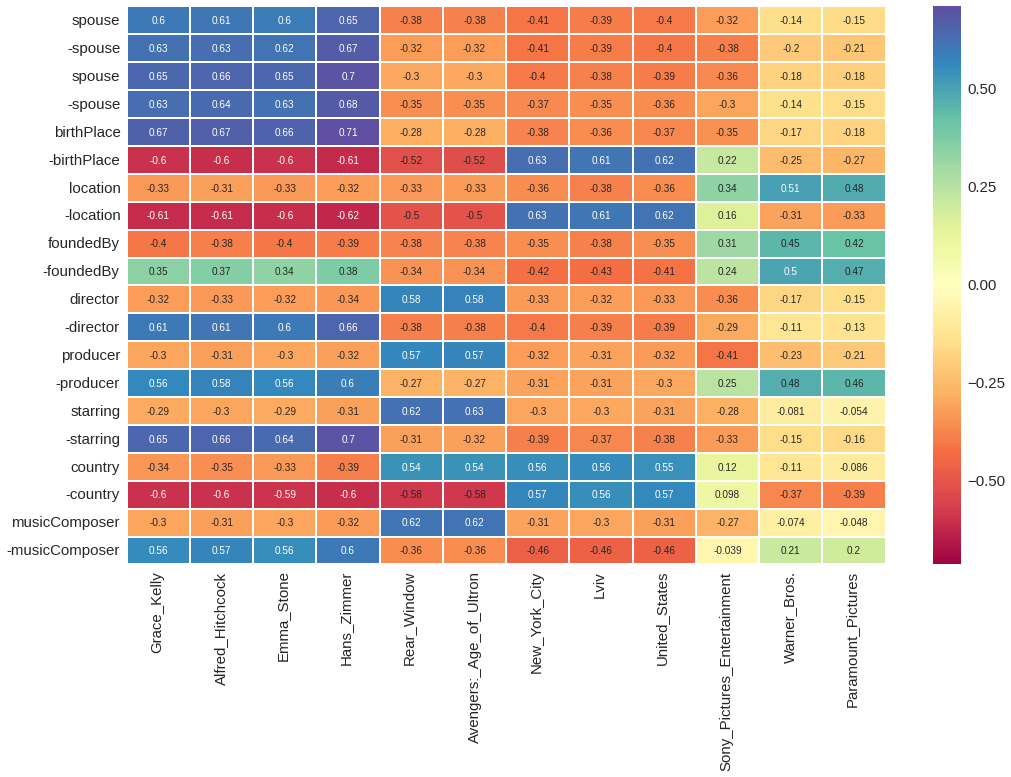

In [60]:
sns.set_context("notebook", font_scale=1.5)
f, ax = plt.subplots(figsize=(17,10))
sns.heatmap(df.T, annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

### Trans-compatibility

In [61]:
trels = [
    "dbo:spouse",
    "dbo:birthPlace",
    "dbo:location",
    "dbo:foundedBy",
    "dbo:producer",
    "dbo:director",
    "dbo:starring",
    "dbo:musicComposer",
]

In [62]:
def computeZXYmetric(t, e, r, f, fd, rd, pre):
    tid = rd[dopre(t, prefixes)]
    eid = fd[dopre(e, prefixes)]
    rid = fd[dopre(r, prefixes)]
    return f(tid, eid, rid)

In [63]:
tdfs = {}
for trel in trels:
    totdf = []
    for ent in ents:
        row = []
        for rel in rels:
            row.append(computeZXYmetric(trel, ent, rel, m.embedXYZdot, fd, rd, prefixes))
        totdf.append(row)
    tdf = pd.DataFrame(totdf)
    tdf.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)
    tdf.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)
    tdfs[trel] = tdf


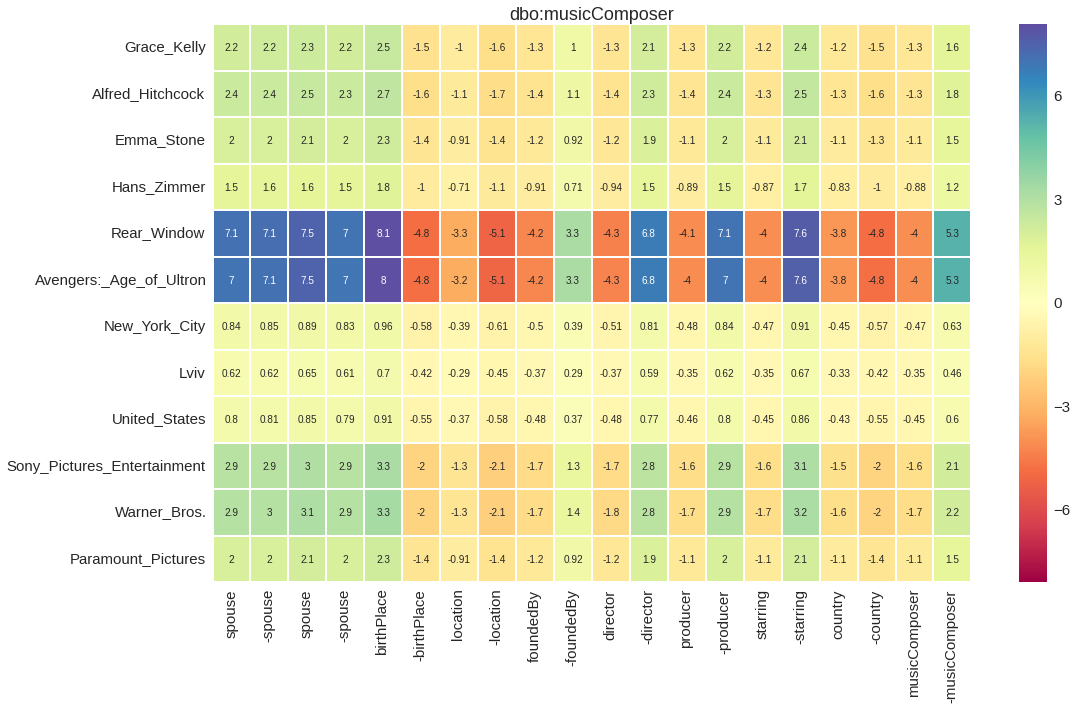

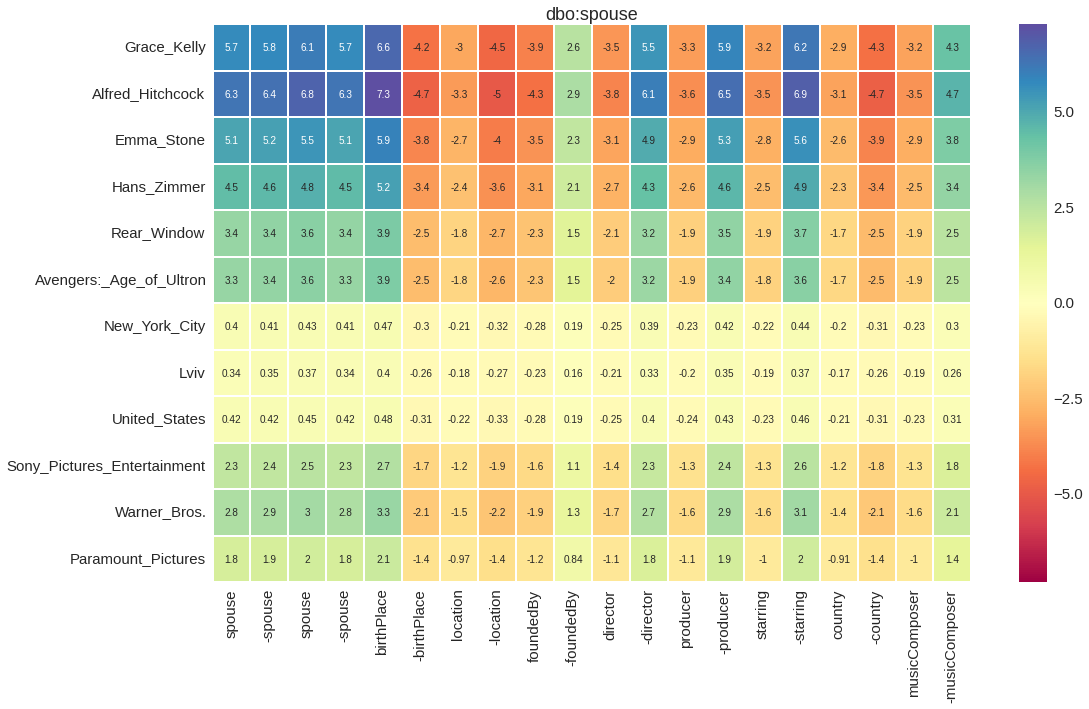

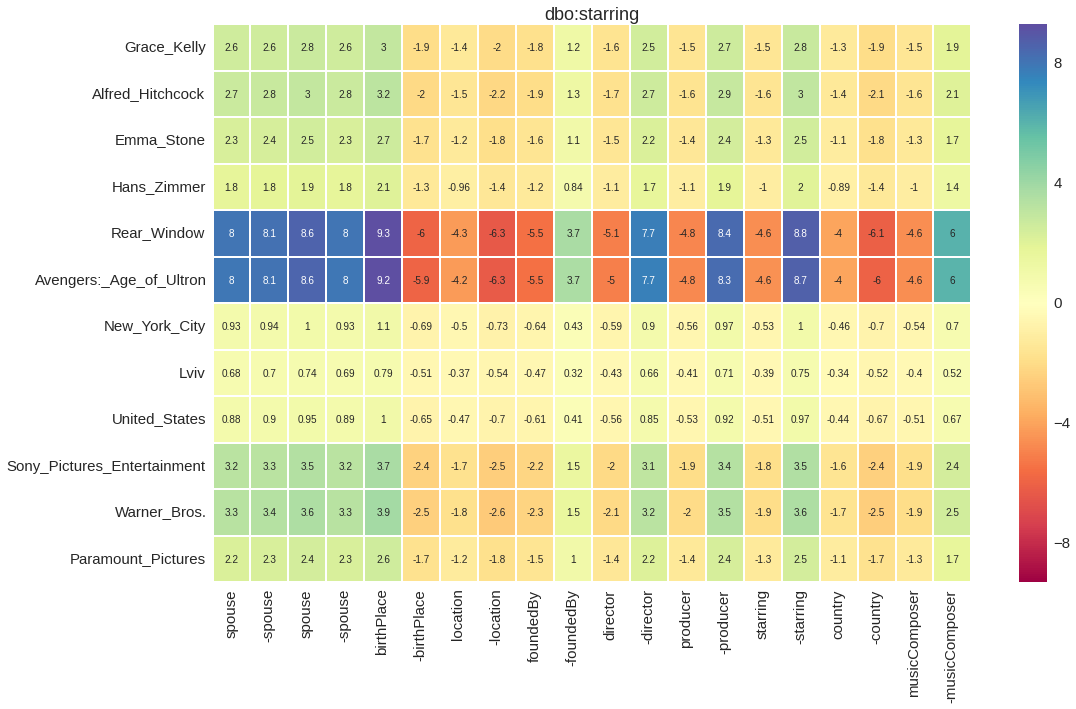

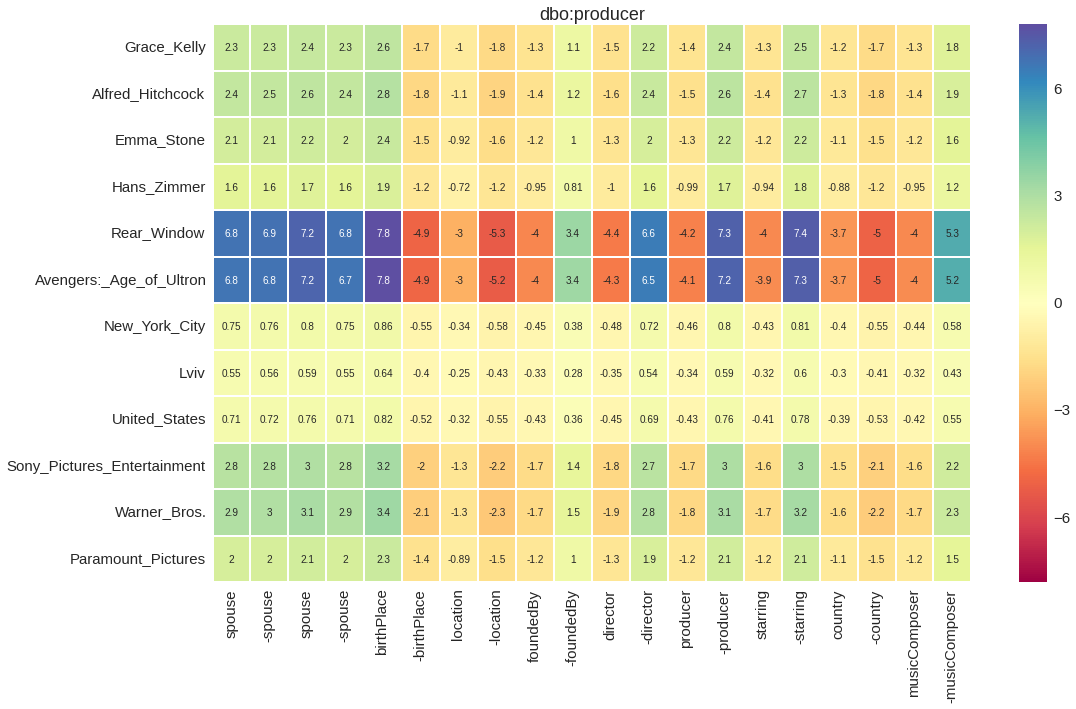

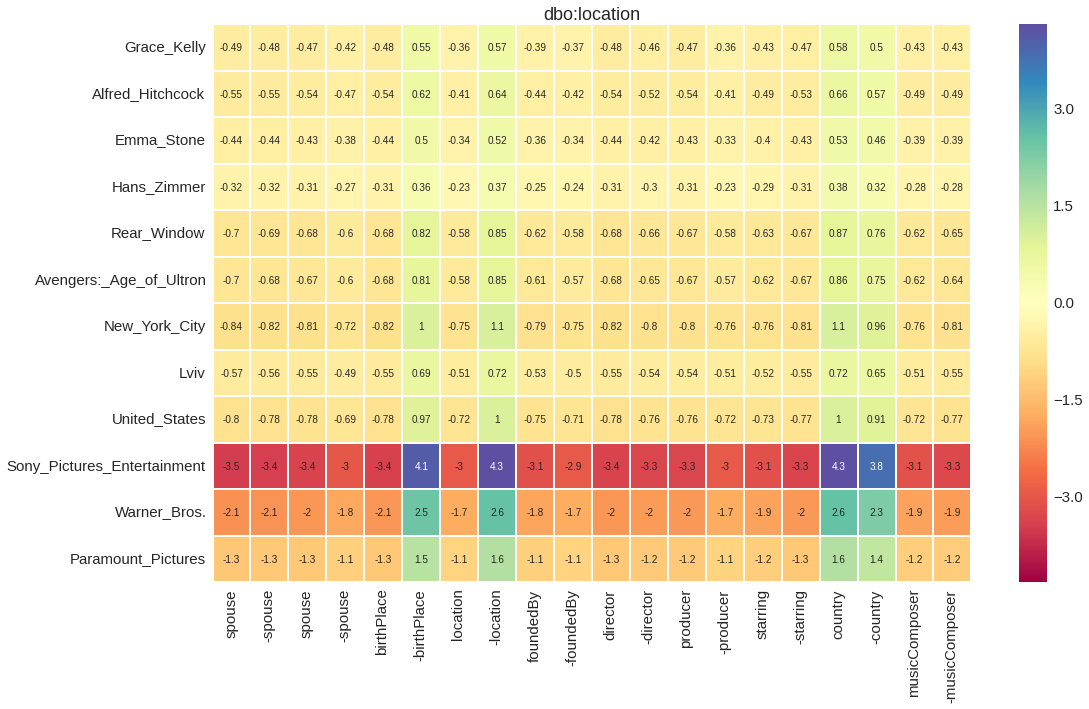

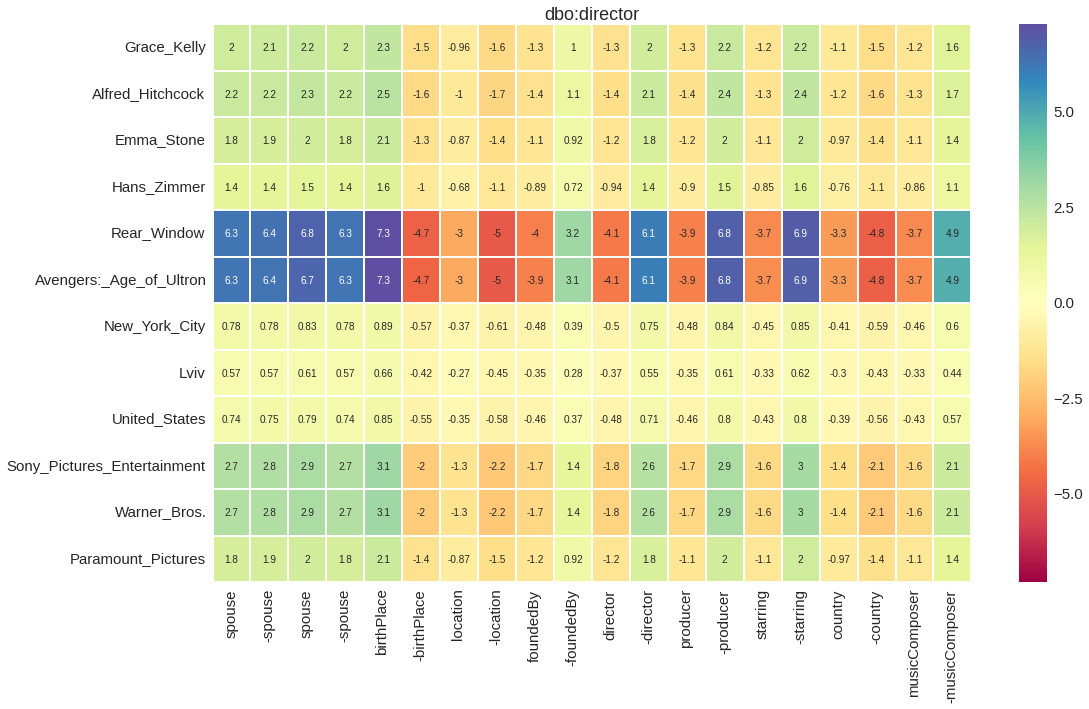

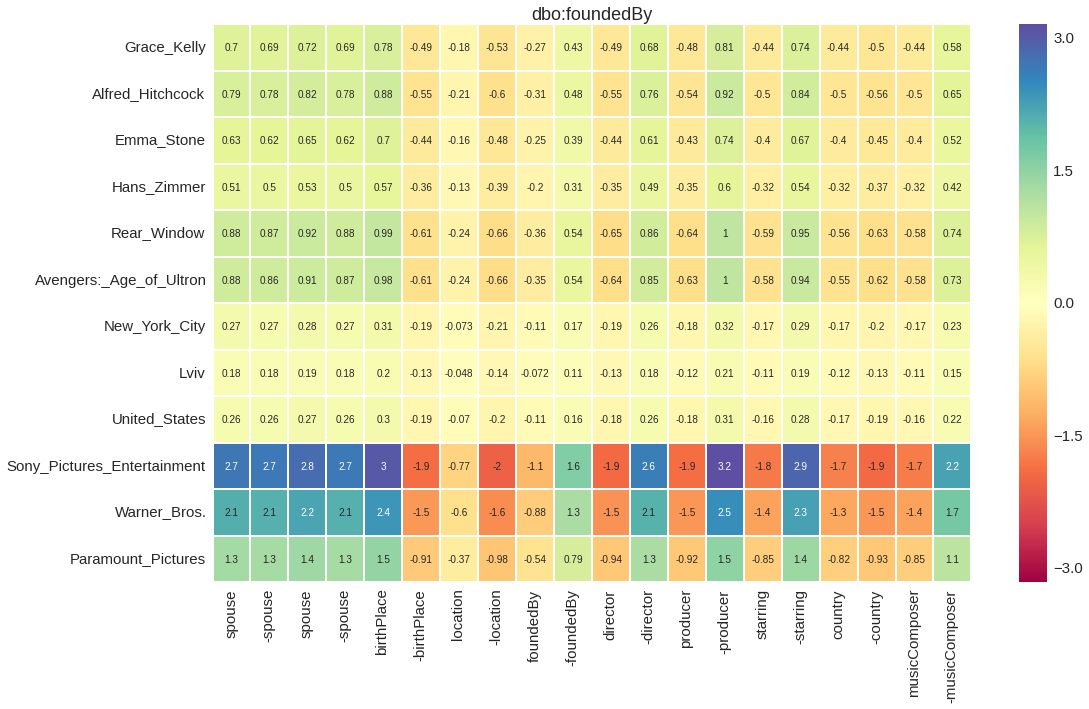

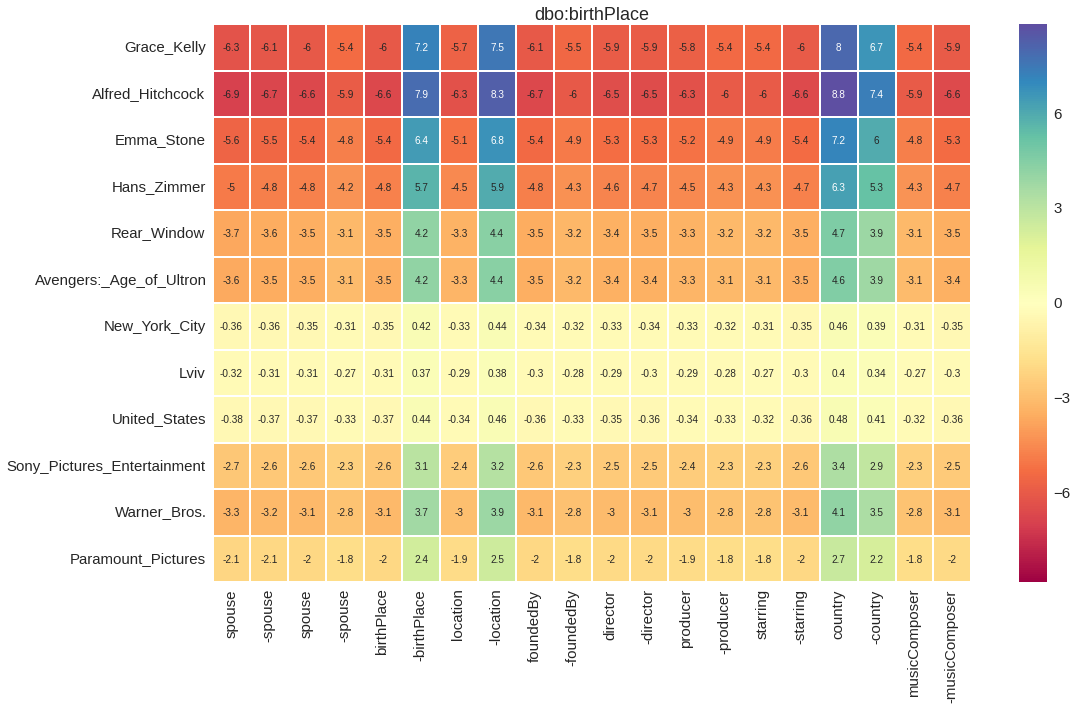

In [64]:
for tdf in tdfs:
    f, ax = plt.subplots(figsize=(17,10))
    ax.set_title(tdf)
    hm = sns.heatmap(tdfs[tdf], annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

### Chains compat (trans-trans-compat): TODO

In [65]:
chains = [
    ["dbo:spouse", "dbo:birthPlace"],
    ["dbo:producer", "dbo:birthPlace"],
    ["-dbo:producer", "dbo:starring"],
    ["dbo:director", "-dbo:producer"],
    ["-dbo:musicComposer", "-dbo:spouse"]
]

In [66]:
trelre = re.compile("(-?)(.+)")
def maptrel(tr, rd, pre):
    if trelre.match(tr):
        rev = -1 if len(trelre.match(tr).group(1)) > 0 else 1
        tid = rd[dopre(trelre.match(tr).group(2), pre)]
        return tid, rev
    else:
        print "WEIRD!"
        return
    
def computeZZXYdot(t, tt, e, r, m, fd, rd, pre):
    tid, tid_dir = maptrel(t, rd, pre)
    ttid, ttid_dir = maptrel(tt, rd, pre)
    eid = fd[dopre(e, pre)]
    rid = fd[dopre(r, pre)]
    tvec = m.embedZ(tid)
    ttvec = m.embedZ(ttid)
    evec = m.embedXY(eid)
    rvec = m.embedXY(rid)
    vec = evec
    tvecchain = [tvec, ttvec]
    tvecchaindirs = [tid_dir, ttid_dir]
    for qsdf, tvecc in enumerate(tvecchain):
        vec = tfth.transform(vec, tvecc) if tvecchaindirs[qsdf] > 0 else tfth.transform(tvecc, vec)
    return tfth.getcompat(vec, rvec)

In [67]:
ttdfs = {}
for chain in chains:
    tottdf = []
    for ent in ents:
        row = []
        for rel in rels:
            row.append(computeZZXYdot(chain[0], chain[1], ent, rel, m, fd, rd, prefixes))
        tottdf.append(row)
    ttdf = pd.DataFrame(tottdf)
    ttdf.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)
    ttdf.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)
    ttdfs[tuple(chain)] = ttdf


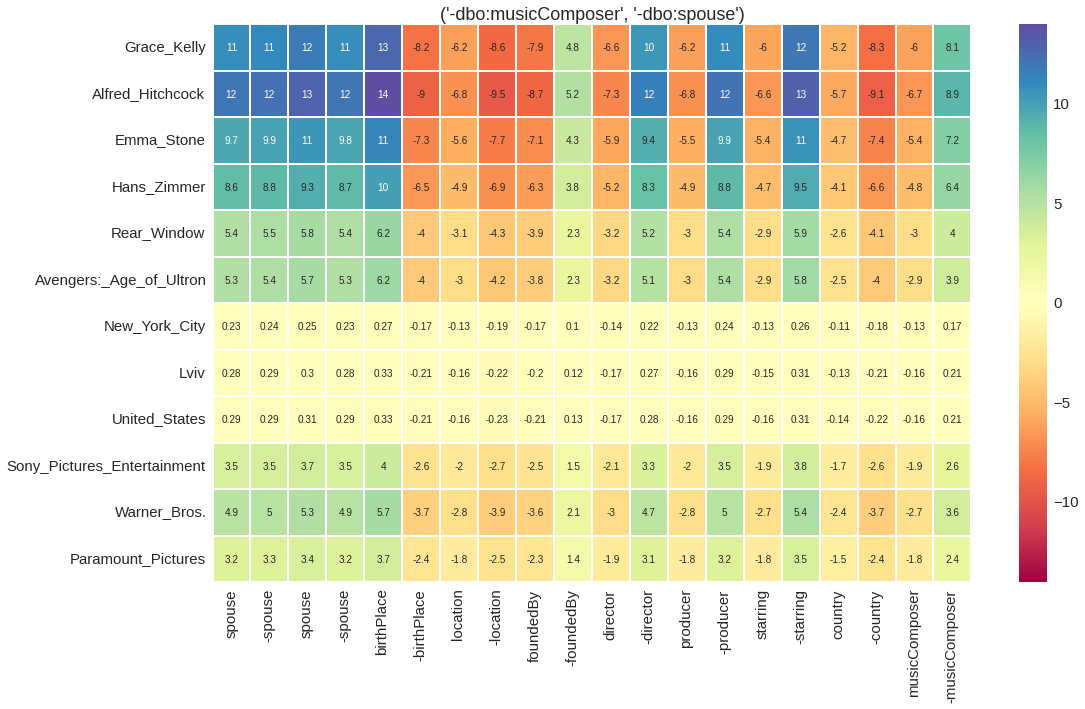

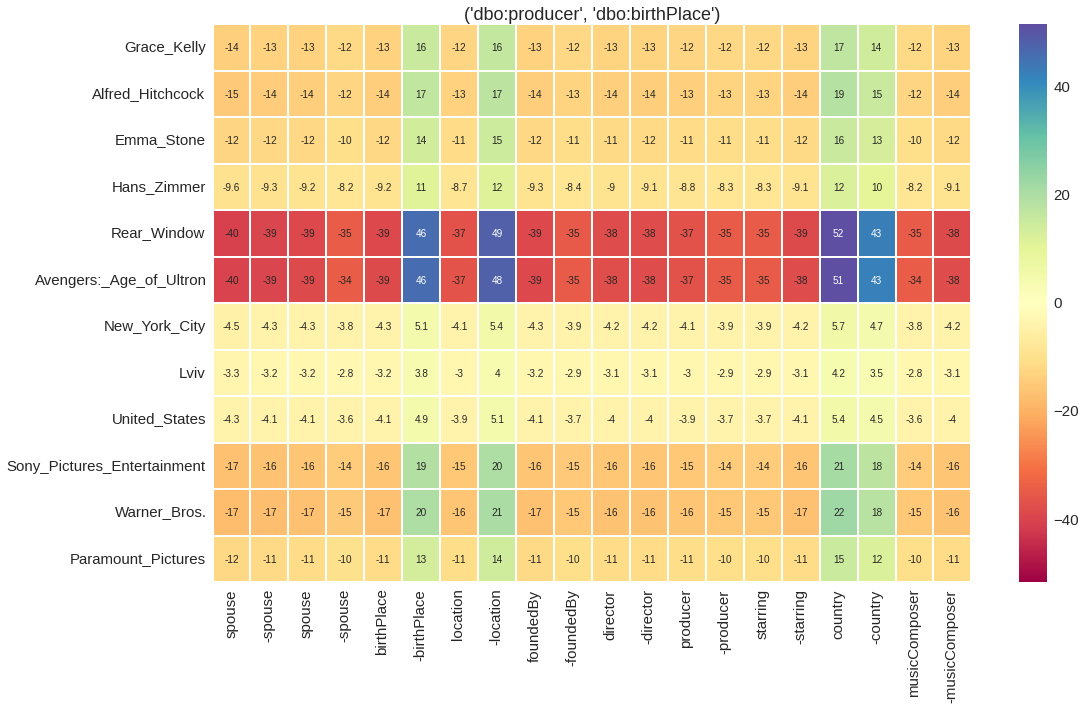

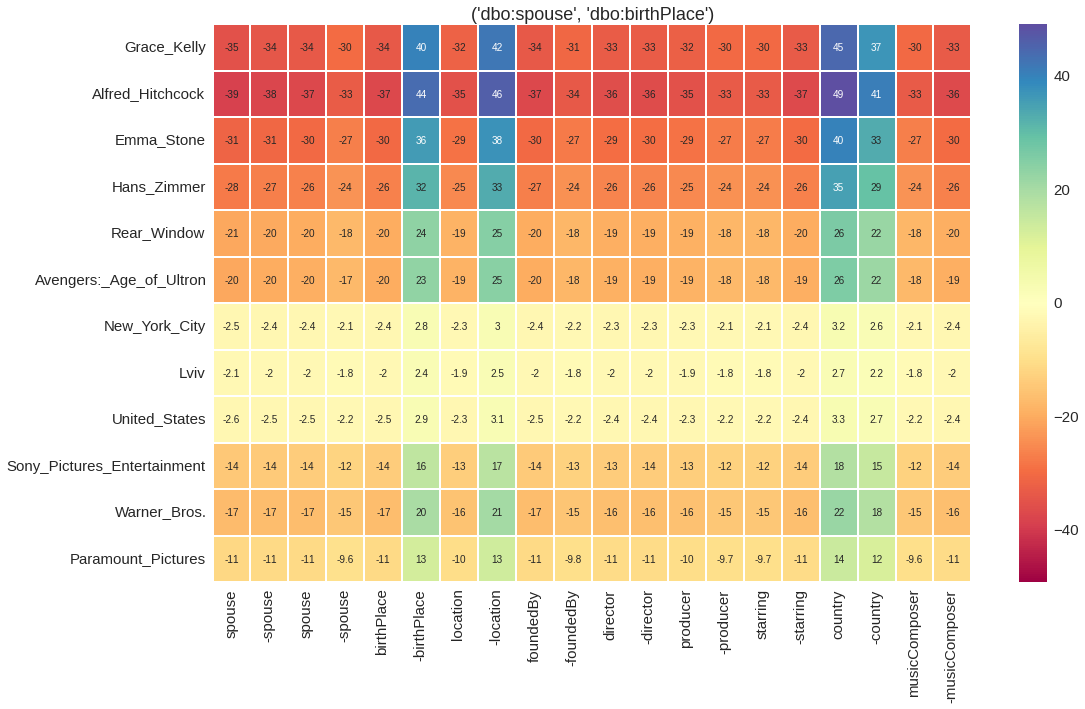

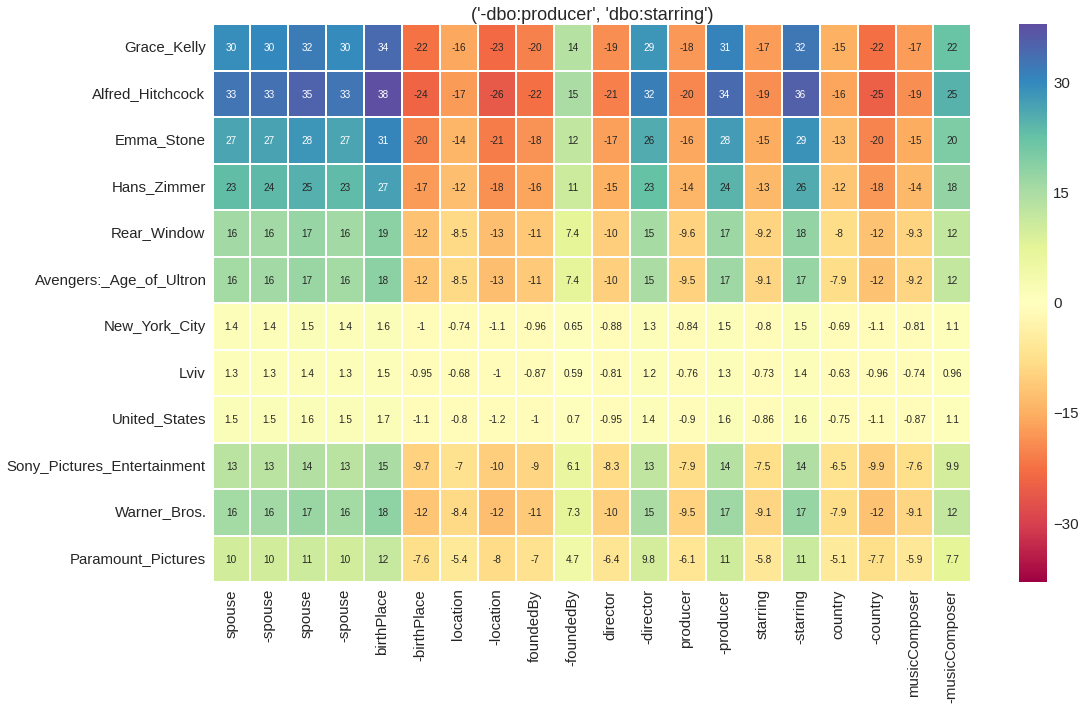

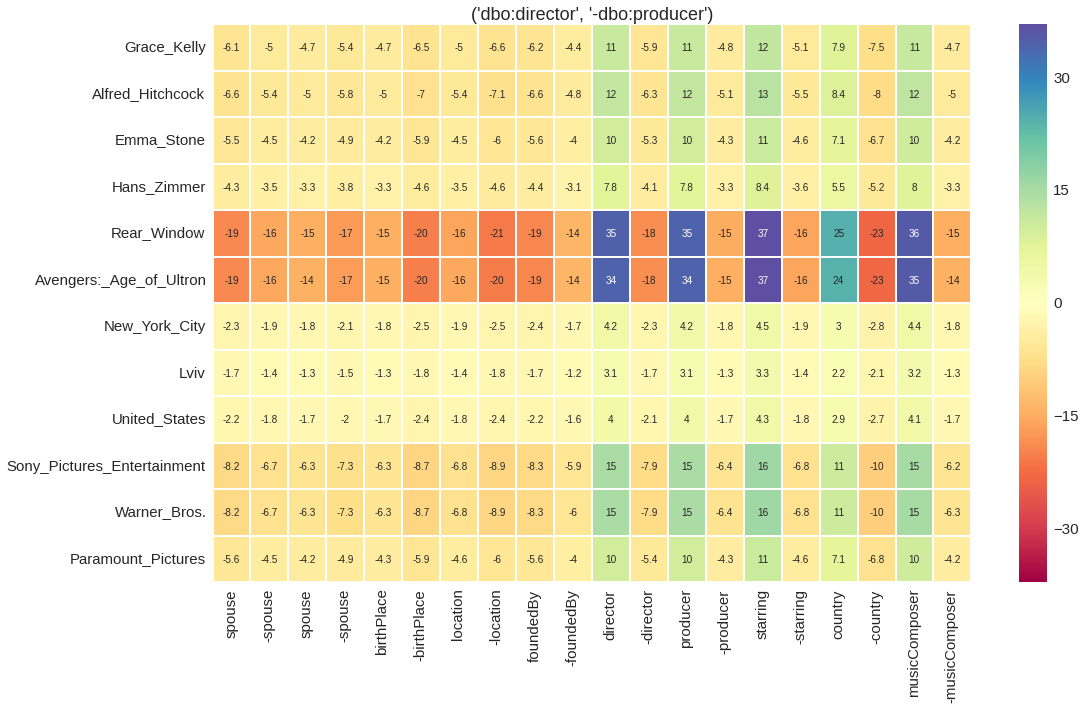

In [68]:
for ttdf in ttdfs:
    f, ax = plt.subplots(figsize=(17,10))
    ax.set_title(ttdf)
    hm = sns.heatmap(ttdfs[ttdf], annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

### Relation-relation compat

In [69]:
rtodf = []
for rel in rels:
    row = []
    for rel2 in rels:
        row.append(computemetric(rel, rel2, m.embedXYcos, fd, prefixes))
    rtodf.append(row)

rdf = pd.DataFrame(rtodf)
rdf.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)
rdf.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), rels)

In [70]:
mask = np.ones(rdf.shape,dtype='bool')
mask[np.tril_indices(len(rdf))] = False
rdf = rdf.mask(mask)

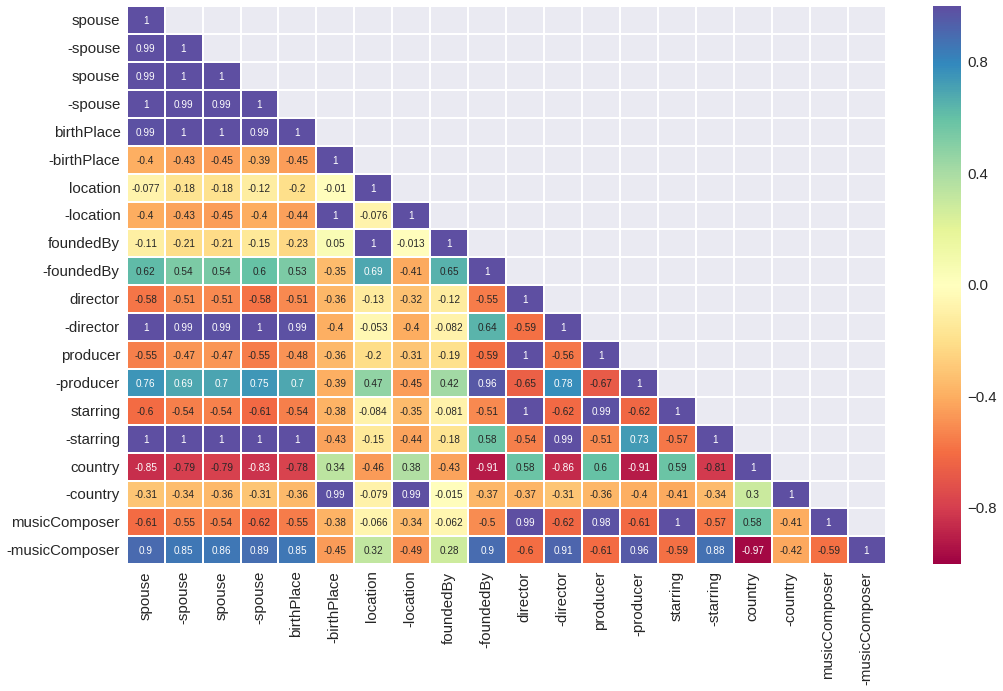

In [71]:
f, ax = plt.subplots(figsize=(17,10))
sns.heatmap(rdf, annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

### Entity-entity compat

In [72]:
etodf = []
for ent in ents:
    row = []
    for ent2 in ents:
        row.append(computemetric(ent, ent2, m.embedXYcos, fd, prefixes))
    etodf.append(row)

edf = pd.DataFrame(etodf)
edf.columns = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)
edf.index = map(lambda x: prefixre.match(x).group(1)+prefixre.match(x).group(3), ents)

In [73]:
mask = np.ones(edf.shape,dtype='bool')
mask[np.tril_indices(len(edf))] = False
edf = edf.mask(mask)

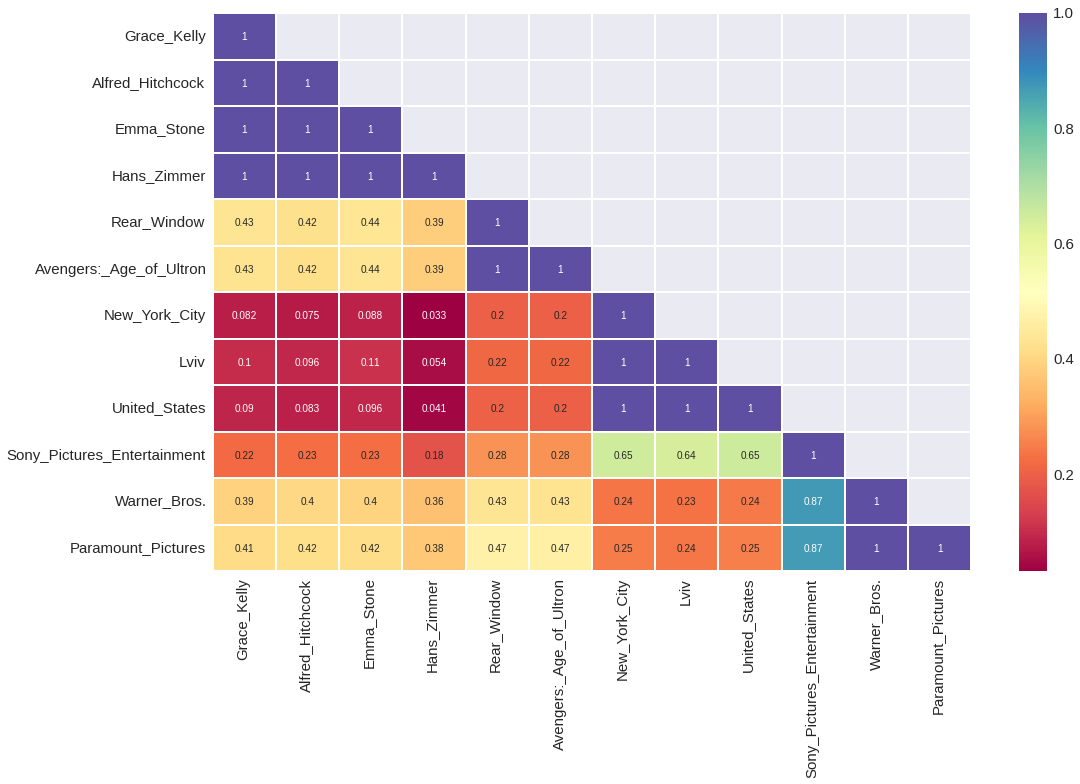

In [74]:
f, ax = plt.subplots(figsize=(17,10))
sns.heatmap(edf, annot=True, linewidths=1.0, ax=ax, cmap="Spectral")

#### What do entities look like?

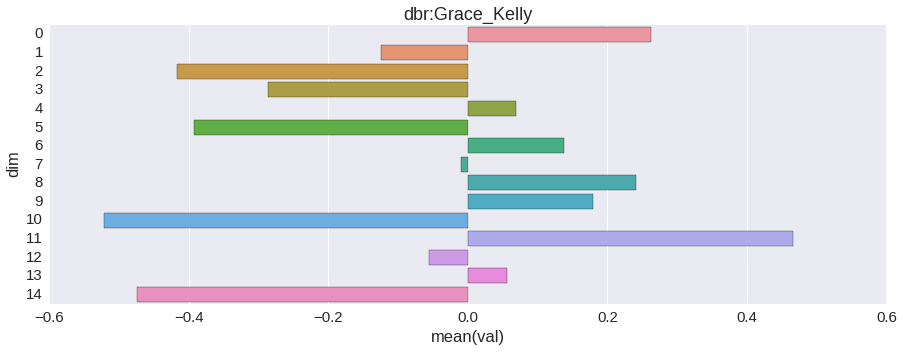

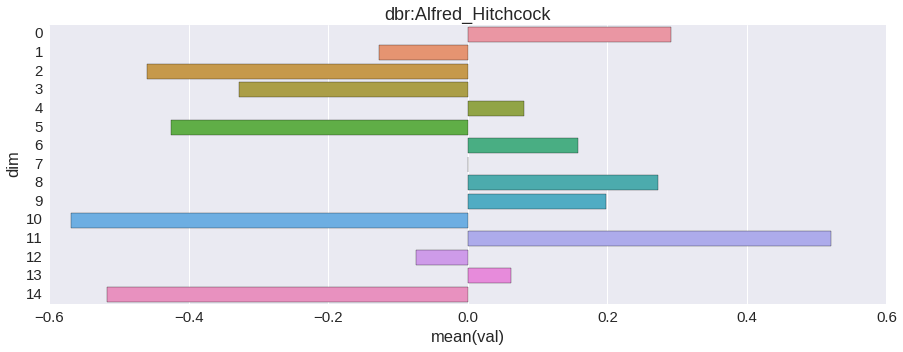

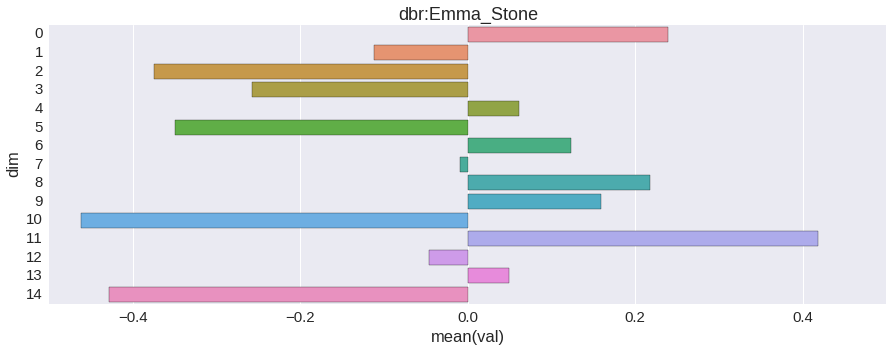

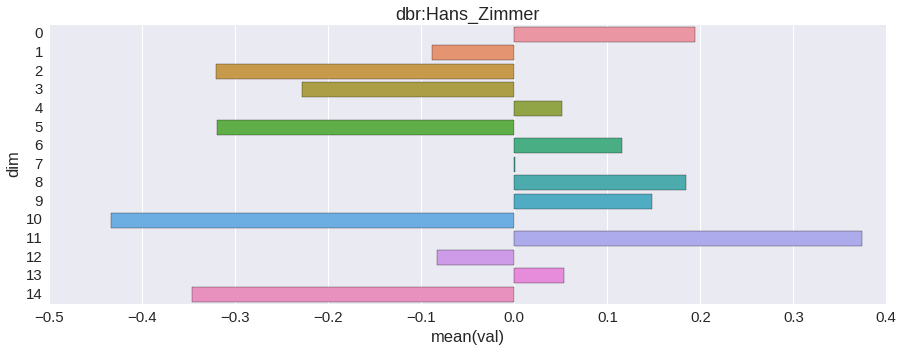

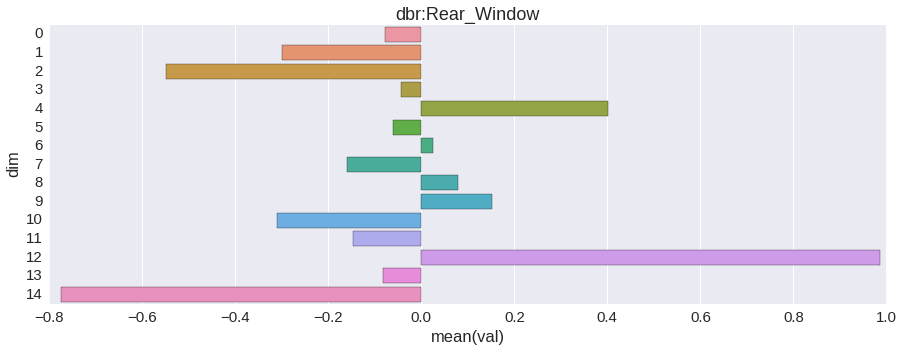

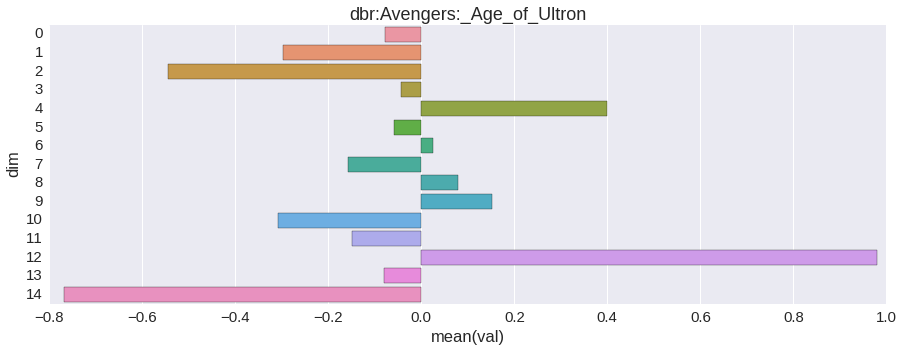

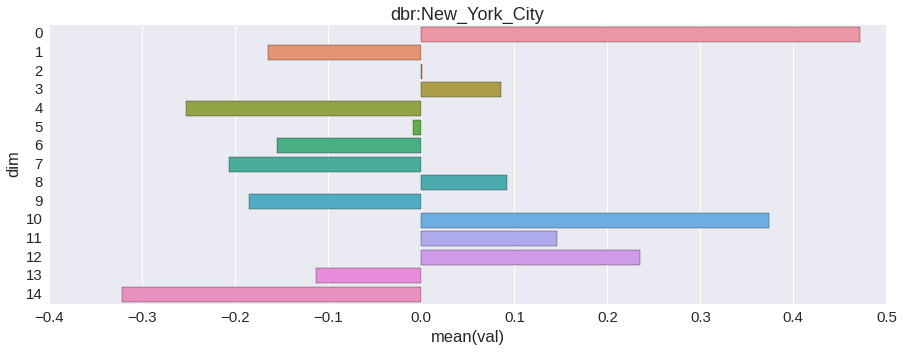

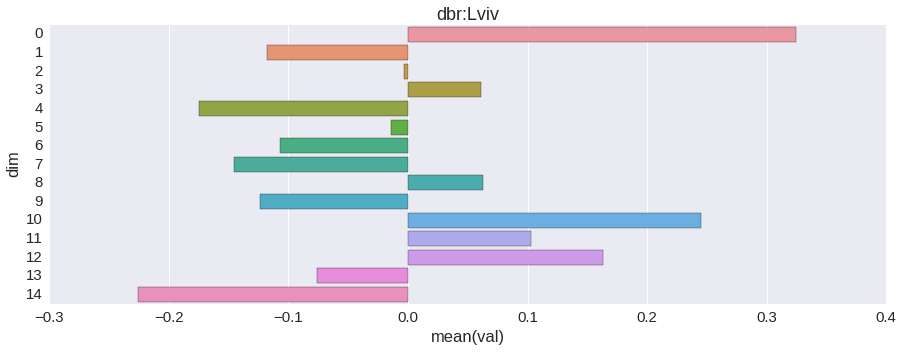

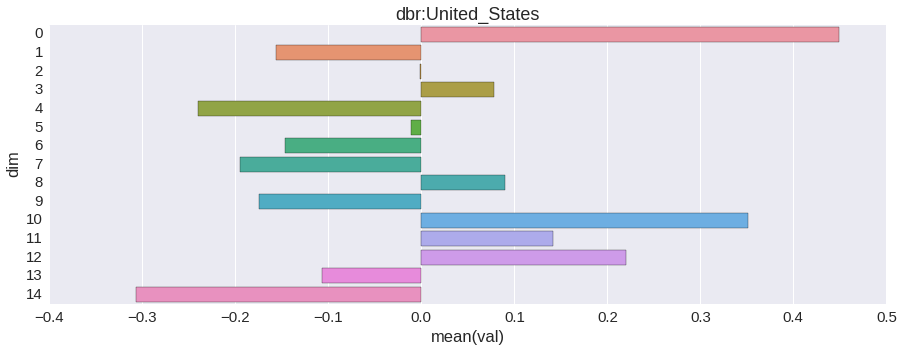

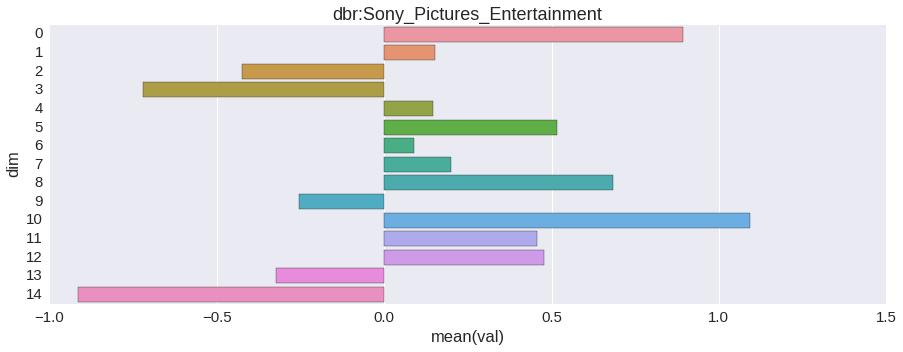

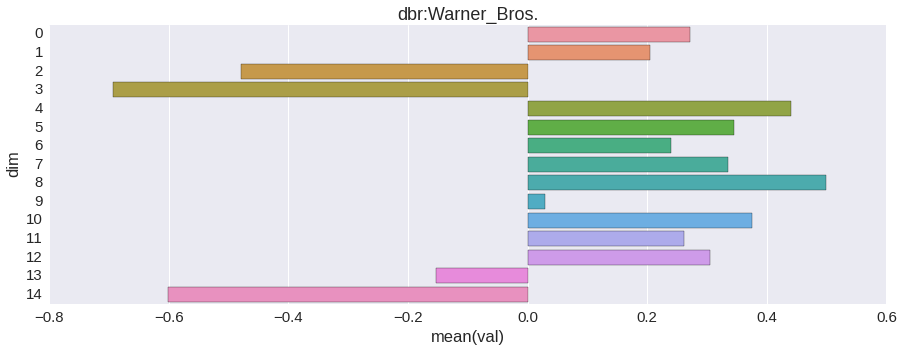

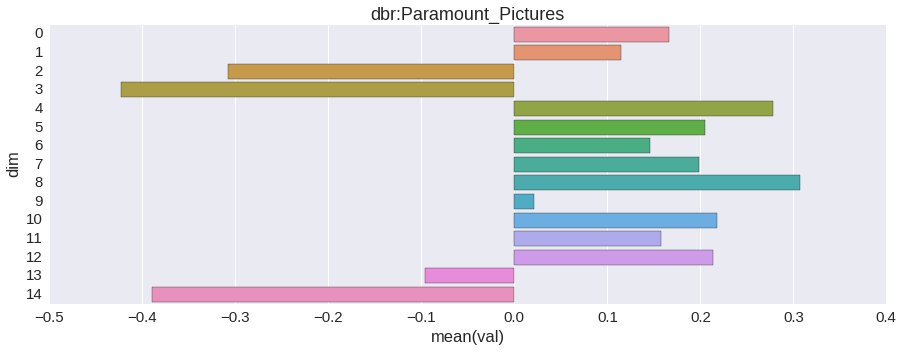

In [75]:

for ent in ents:
    entemb = m.embedXY(fd[dopre(ent, prefixes)])
    entembdf = pd.DataFrame(zip(range(len(entemb)), entemb), columns=["dim", "val"])
    f, ax = plt.subplots(figsize=(15,5))
    ax.set_title(ent)
    sns.barplot(x="val", y="dim", data=entembdf, ax=ax, orient="h")

#### What do relations look like?

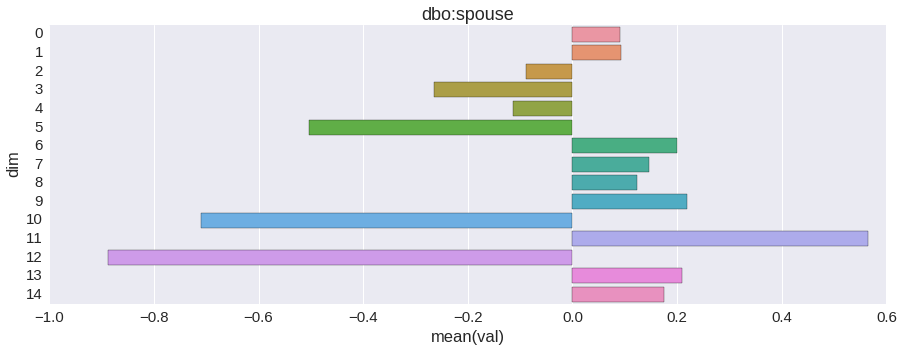

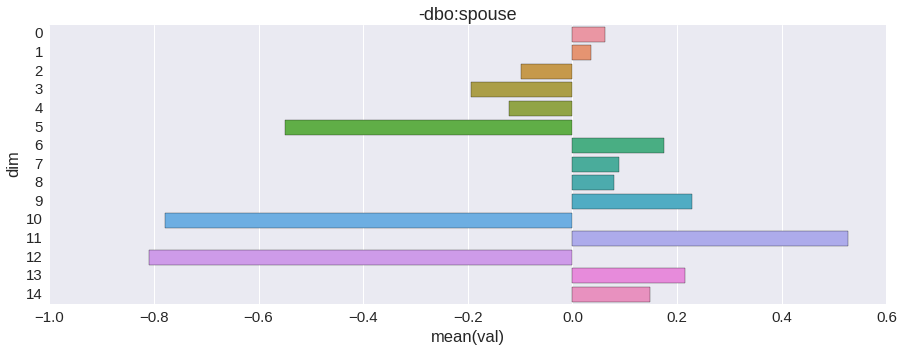

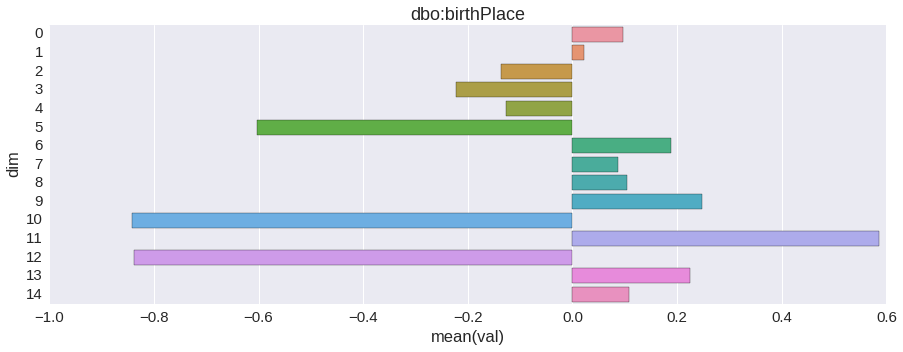

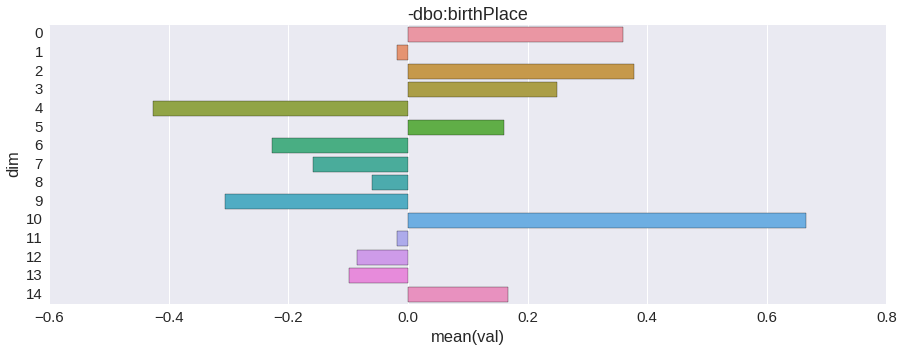

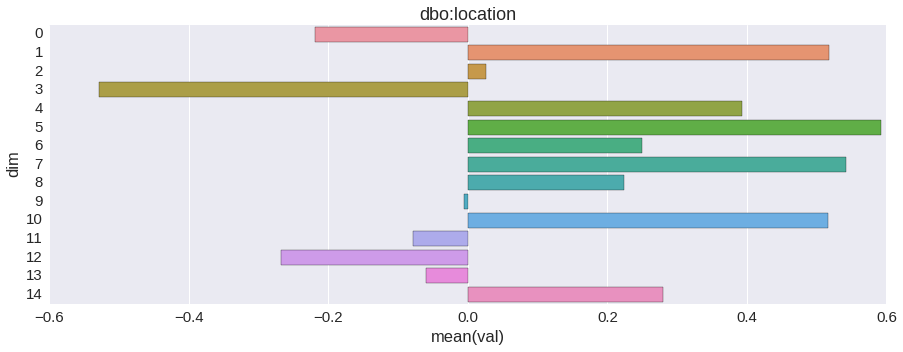

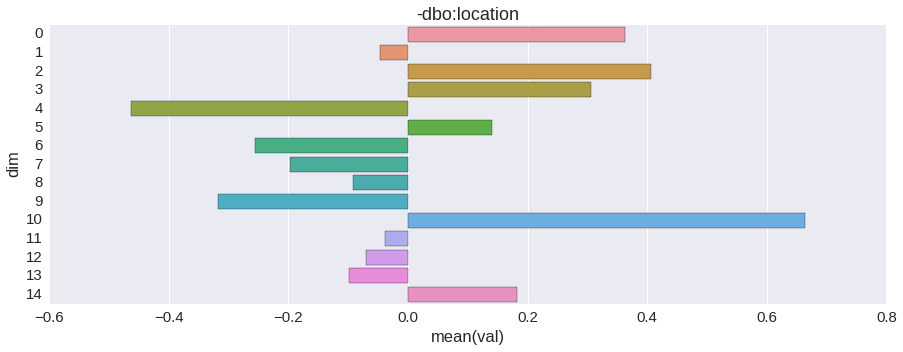

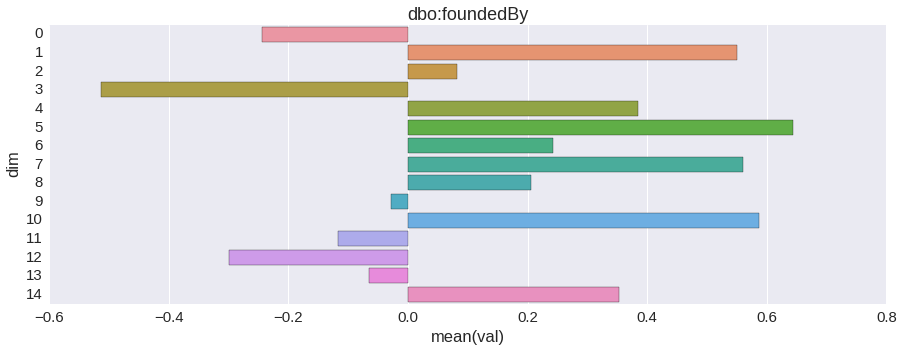

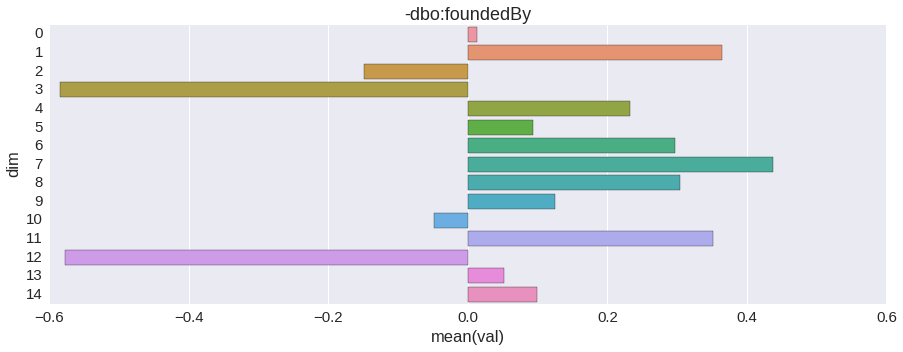

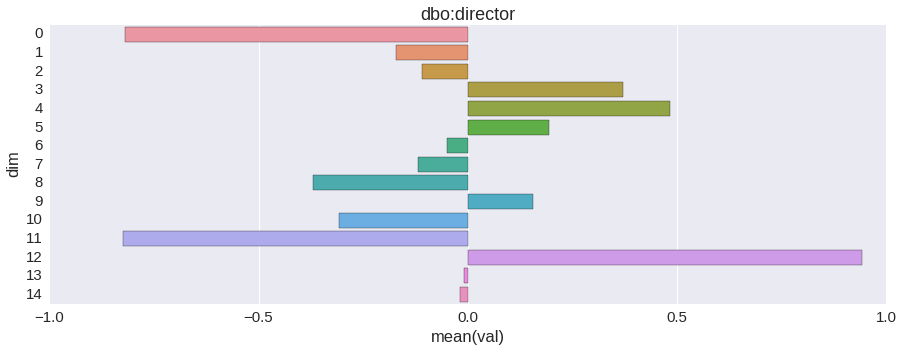

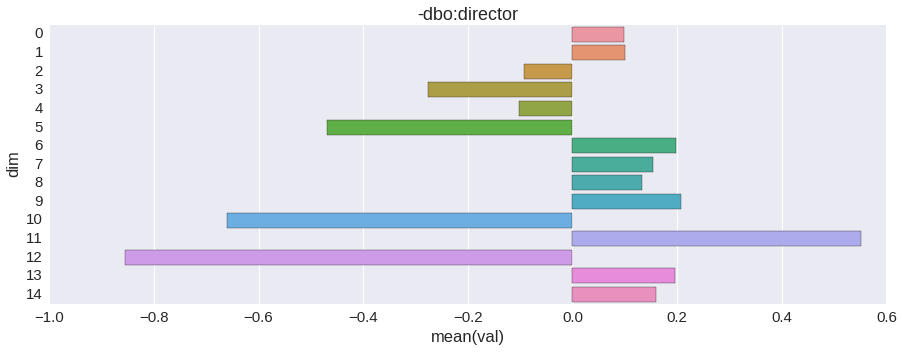

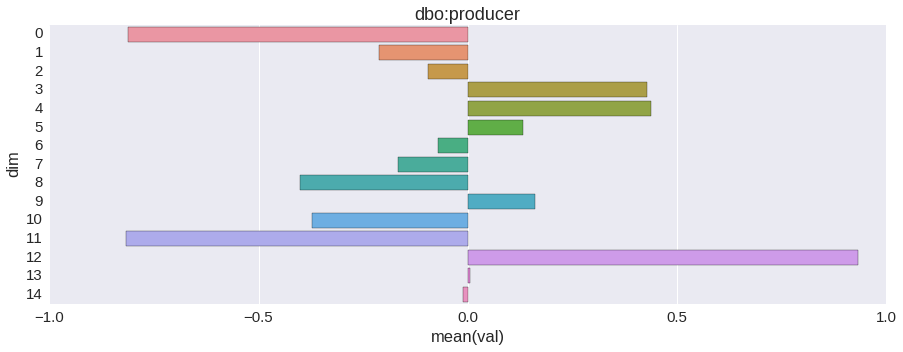

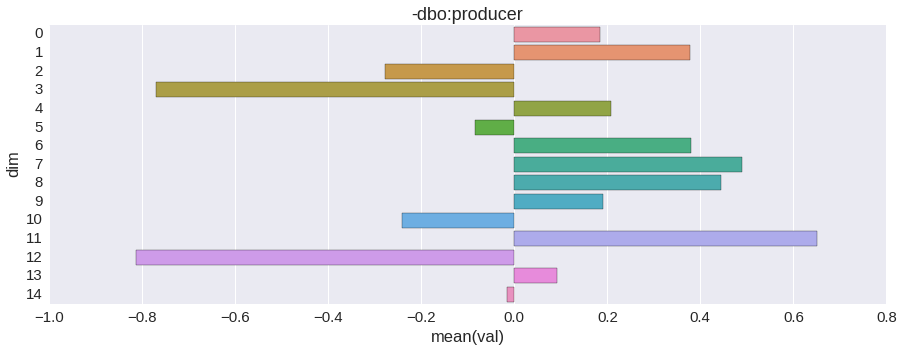

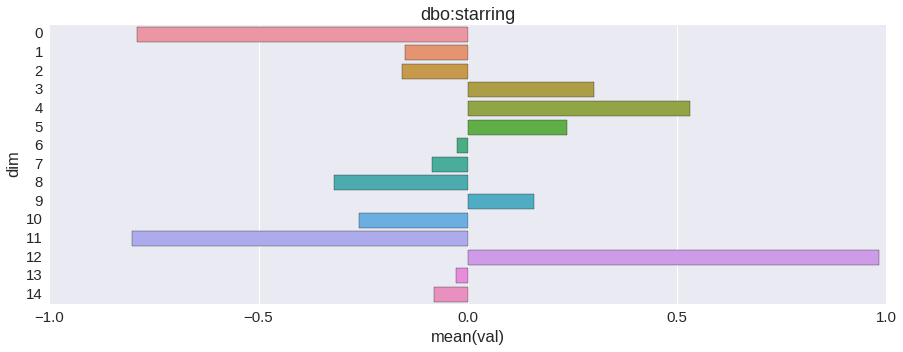

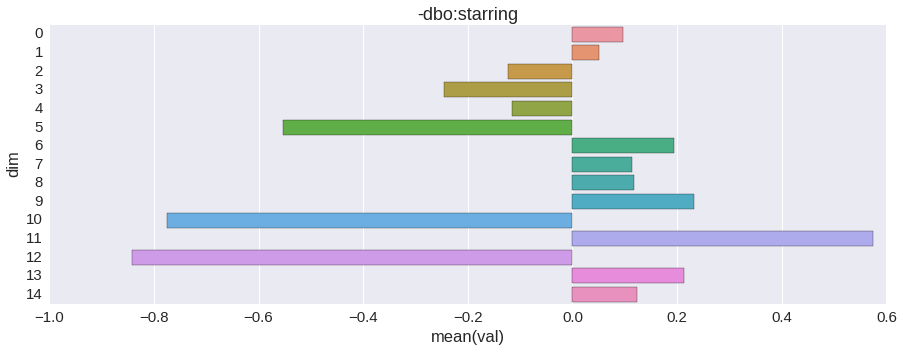

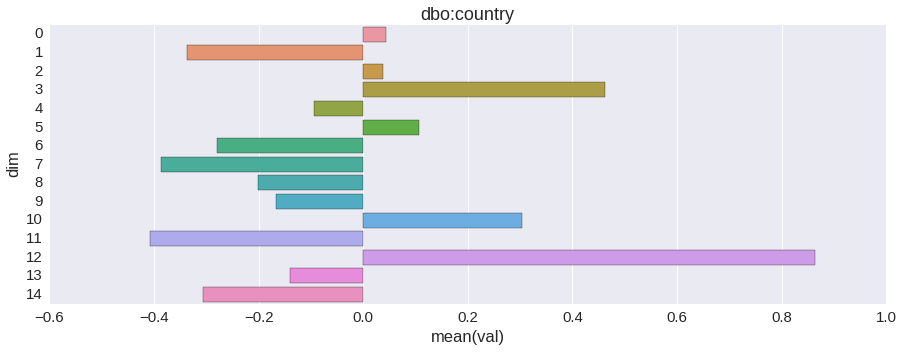

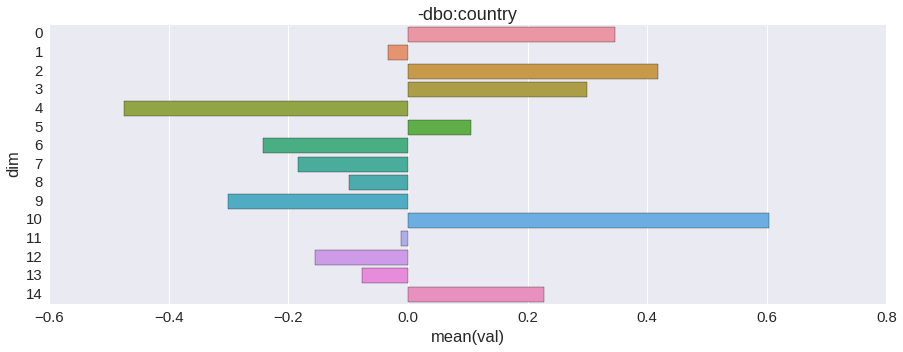

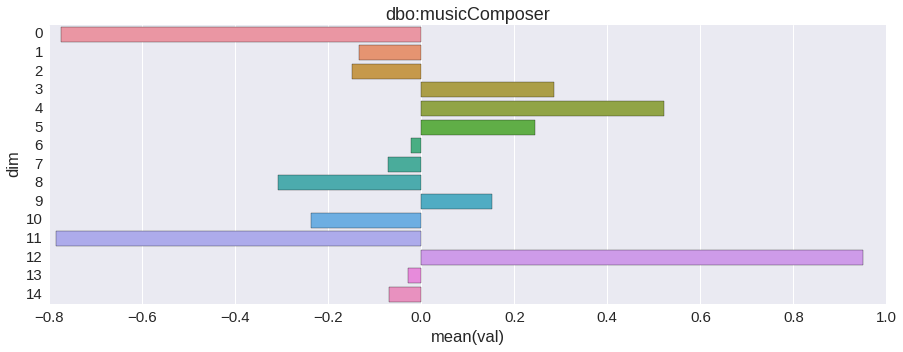

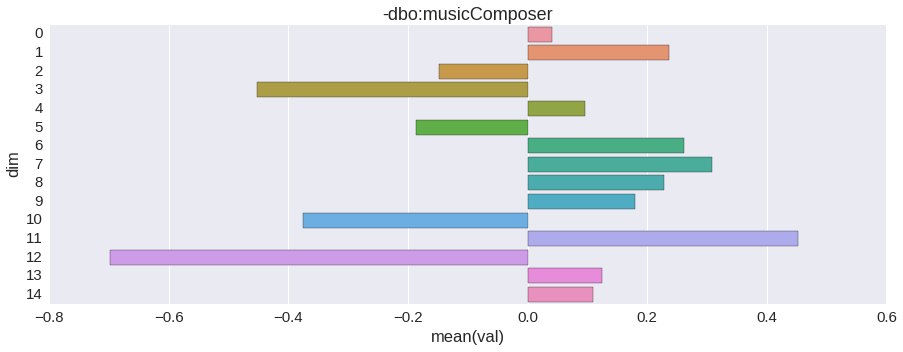

In [46]:
for ent in rels:
    entemb = m.embedXY(fd[dopre(ent, prefixes)])
    entembdf = pd.DataFrame(zip(range(len(entemb)), entemb), columns=["dim", "val"])
    f, ax = plt.subplots(figsize=(15,5))
    ax.set_title(ent)
    sns.barplot(x="val", y="dim", data=entembdf, ax=ax, orient="h")